<h1>Daten einladen</h1>

In [1]:
import numpy as np
import os

Bei uns sind die Dateien im Verzeichnis data/newsticker gespeichert. Bitte den Pfad bei Bedarf anpassen

In [2]:
os.chdir(os.path.join(os.environ["HOME"], "data", "newsticker" "data"))

Jetzt geht es darum, die Daten einfach einzuladen – wir nutzen hier lediglich die Daten seit 2010,da erst ab dann systematisch Keywords vergeben wurden. Die Analysen benötigen nun kein Pandas, nur sehr viel Speicher. Daher lohnt es sich, RAM zu sparen und die Daten einfach in ein Array einzuladen. 

In [3]:
import json
import numpy as np
from collections import Counter

articles = []
all_keywords = Counter()
for year in range(2010, 2018):
    with open("%d.json" % year) as json_data:
        d = json.load(json_data)
        for m in d:
            try:
                keywords = m["keyword"]
                for k in keywords:
                    all_keywords[k] += 1
            except:
                keywords = []
            document = [m["headline"], m["text"], keywords]
            articles.append(document)

Damit man sich einen Eindruck vom Umfang verschaffen kann, sollte man die Anzahl der Keywords und Artikel überprüfen.

In [4]:
len(all_keywords)

41413

In [5]:
len(articles)

77410

<h1>Machine Learning mit Keywords</h1>

<h2>Vektorisierung</h2>

Methode: 

Texte werden in ein Array gewandelt, dabei repräsentiert jede Zeile ein Dokument und jede Spalte ein Keyword. Dokumenten enthalten jedes Keyword höchstens einmal, daher steht an der Position eine 1, wenn das Keyword im Dokument enthalten ist, sonst eine 0

Um nicht über alle Keywords iterieren zu müssen, ist es sinnvoll, sich die Position der Keywords (also praktisch die Nummer der Spalte) zu merken.

In [6]:
keyword_pos = {}
# hier kann die Anzahl angepasst werden
for i, keyword in enumerate(all_keywords.most_common(41413)):
    keyword_pos[keyword[0]] = i

Es gibt sehr viele Keywords und sehr viele Dokumente. Die Document-Keyword-Matrix wird damit sehr groß (> 100 Millionen Einträge). Das kostet einerseits extrem viel Speicher und ist andererseits auch hinderlich für die Machine-Learning-Verfahren.

Jedes Dokument selbst hat nur wenige Keywords, d.h. die Matrix ist dünn belegt. Für sog. Sparse Matrices gibt es in numpy/scipy sehr leistungsfähige Datenstrukturen, die nur wenig Speicher benötigen. Allerdings ist der Aufbau einer solchen Sparse Matrix etwas schwierig.

Zuerst wird eine Hilfsstruktur benötigt, die dann einfach in eine dünn belegte Spaltenmatrix umgewandelt werden kann. Das geht sehr schnell. Damit man sich davon überzeugen kann, wurde der Timing-Modus von Jupyter mit %time eingeschaltet.

In [7]:
%time
from scipy.sparse import csr_matrix

data = []
indices = []
indptr = [0]
for doc in articles:
    for keyword in doc[2]:
        # evtl. existiert der key nicht
        try:
            indices.append(keyword_pos[keyword])
            data.append(1)
        except:
            pass
    indptr.append(len(indices))
    
matrix = csr_matrix((data, indices, indptr), dtype=np.int8)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [8]:
matrix

<77410x41413 sparse matrix of type '<class 'numpy.int8'>'
	with 296804 stored elements in Compressed Sparse Row format>

Mehr Informationen zu scipy: https://scipy.org

Mehr Informationen zu den Spaltenmatrizen mit Programmbeispielen: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix

<h2>Clustering mit mit K-Means</h2>

In diesem Beispiel wird zunächst der K-Means Algorithmus zum unüberachten maschinellen Lernen verwendet.

Mehr Informationen zu K-Means: https://de.wikipedia.org/wiki/K-Means-Algorithmus

Achtung, K-Means ist ein statistisches Verfahren und liefert jedesmal unterschiedliche Ergebnisse. Daher wird das Random Seed in numpy auf einen festen Wert gesetzt. Anschließend wird der Algorithmus mit der Anzahl der Cluster initialisiert, schließlich das eigentliche Clustering mit fit gestartet. Wir geben 6 Cluster vor.

In diesem Beispiel wurde der Standard-Algorithmus von scikit-learn benutzt. Im Einzelfall kann es mit MiniBatchKMeans schneller gehen, ein Vergleich lohnt sich.

Mehr Informationen zu K-Means bei scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html und http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

In [9]:
from sklearn.cluster import KMeans
np.random.seed(0)
clusters = 6
k_means = KMeans(n_clusters=clusters)
k_means.fit(matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Sechs Cluster waren vorgegeben, wie viele Dokumente sind in den Clustern?

In [10]:
labels1 = k_means.labels_
np.unique(k_means.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([ 2526,  2959,  1331, 66147,  1429,  3018]))

Um die Stabilität des Verfahrens zu überprüfen, sollte man den Algorithmus mehrfach laufen lassen. Es ist unwahrscheinlich, das sich bei so großen Datenmengen (bis auf Permutationen) das exakt identische Ergebnis ergibt, allerdings sollten die gefundenen Cluster ungefähr gleich groß sein.

In [11]:
k_means.fit(matrix)
labels2 = k_means.labels_
np.unique(k_means.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([ 2095, 69310,  1443,   196,  3979,   387]))

Neben der ähnlichen Verteilung der Clustergrößen lässt sich auch formal berechnen, wie verschieden die Ergebnisse sind. Dazu dient das metrics-Paket von scikit-learn.

Mehr zu den Metriken für Cluster: http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation

In [12]:
from sklearn import metrics

metrics.adjusted_mutual_info_score(labels1, labels2)

0.31174597384337199

1.0 wäre 100% Übereinstimmung.

<h2>Alternative Clusteringverfahren</h2>

scikit-learn bietet eine Vielzahl an Clusteringverfahren an, ein Überblick über deren Verhalten bei unterschiedliche strukturierten Datenmengen findet sich bei http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

Im vorliegenden Fall könnten auch Birch und DBSCAN zum Einsatz kommen, diese sind allerdings um viele Größenordnungen langsamer als K-Means und brauchen sehr viel mehr Speicher:

In [13]:
from sklearn import cluster

dbscan = cluster.DBSCAN(eps=0.3)
birch = cluster.Birch(n_clusters=6)

Achtung, entfernen Sie die Kommentare bei den folgenden Zellen nur dann, wenn Sie genügend Arbeitsspeicher (> 32 GB) zur Verfügung haben und stellen Sie sich auf längere Wartezeiten ein.

In [14]:
#birch.fit(matrix)

In [15]:
#dbscan.fit(matrix)

<h2>Welche Dokumenten sind in den Clustern enthalten?</h2>

Zunächst wird eine Funktion definiert, die für jeden Cluster die Top-Keywords ausgibt.

In [16]:
from collections import defaultdict
import operator
def print_cluster_summary(method):
    labels = method.labels_
    unique_labels, counts = np.unique(labels, return_counts=True)
    # ein dict, das im Normalfall ein dict mit Standardwert 0 enthält
    keyword_cluster = defaultdict(lambda: defaultdict(lambda: 0))
    for i, label in enumerate(labels):
        for k in articles[i][2]:
            keyword_cluster[label][k] += 1
    
    for label, count in zip(unique_labels, counts):
        print("label %d with %d articles" % (label, count))
        # nur die Top-10 anzeigen
        for t in reversed(sorted(keyword_cluster[label].items(), key=operator.itemgetter(1))[-10::]):
            print("  %6d %s" % (t[1], t[0]))

Der Aufruf erfolgt mit print_cluster_summary(k_means), allerdings ist das Resultat nicht besonders übersichtlich.

Man kann sich aber mit den WordClouds aus dem ersten Teil des Tutorials (iX 3/2017) behelfen, diese benötigen auch die Häufigkeit der einzelnen Worte, die über die Cluster relativ einfach erreichnet werden kann. Zunächst wird dazu ein doppelt geschachteltes defaultdict angelegt, das sehr viele Abfragen (bzw. Exceptions) wegen fehlender Keys vermeidet.

Da schließlich auch immer die Clustergröße mit ausgegeben werden soll, hilft die zip-Funktion, um zwei Arrays miteinander wie im Reißverschlussverfahren zusammenzuführen (die Elemente werden dann Zwei-Tupel).

Leider erfolgt die Textausgabe nicht direkt über den Grafiken, diese werden erst am Schluss dargestellt. Da das aber eine Weile dauern kann, ist die Ausgabe der Größe als Fortschrittsindikator sehr praktisch.

Mehr Informationen zu der WordCloud: https://github.com/amueller/word_cloud

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from wordcloud import WordCloud

def wordcloud_cluster_summary(method):
    labels = method.labels_
    unique_labels, counts = np.unique(labels, return_counts=True)
    # ein dict, das im Normalfall ein dict mit Standardwert 0 enthält
    keyword_cluster = defaultdict(lambda: defaultdict(lambda: 0))
    for i, label in enumerate(labels):
        for k in articles[i][2]:
            keyword_cluster[label][k] += 1

    for label, count in zip(unique_labels, counts):
        print("cluster %d with %d articles" % (label, count))
        wc = WordCloud(background_color="white", max_words=1000)
        wc.generate_from_frequencies(keyword_cluster[label])
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off");


cluster 0 with 2095 articles
cluster 1 with 69310 articles
cluster 2 with 1443 articles
cluster 3 with 196 articles
cluster 4 with 3979 articles
cluster 5 with 387 articles


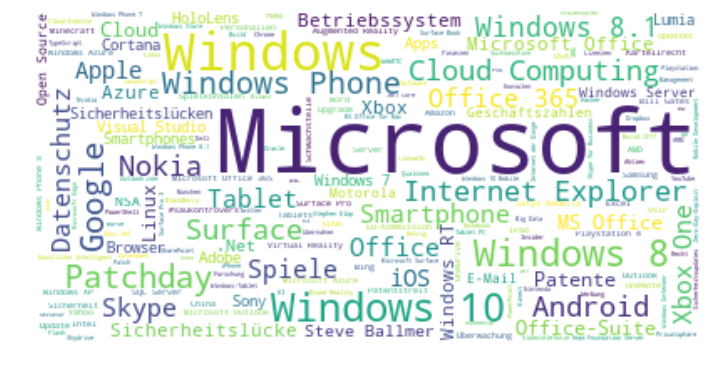

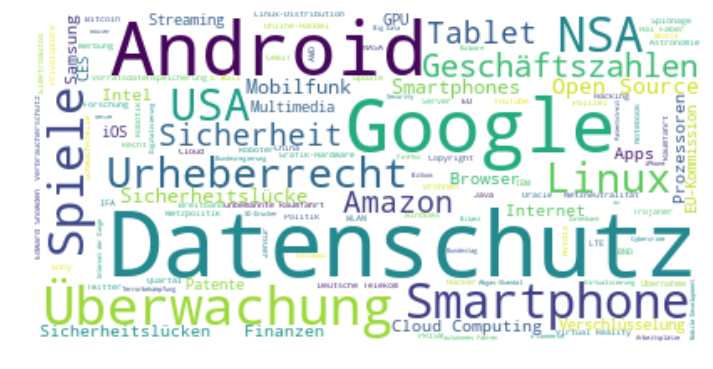

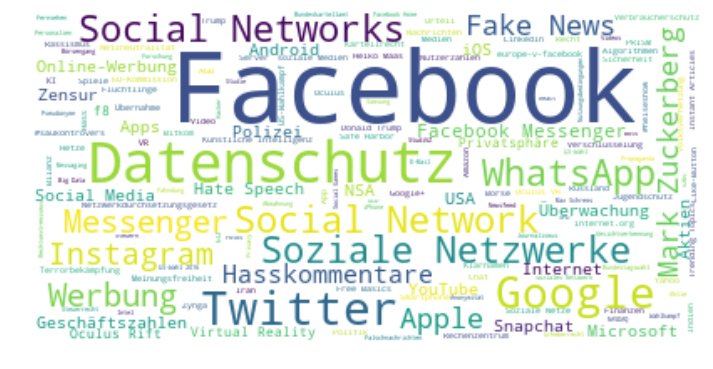

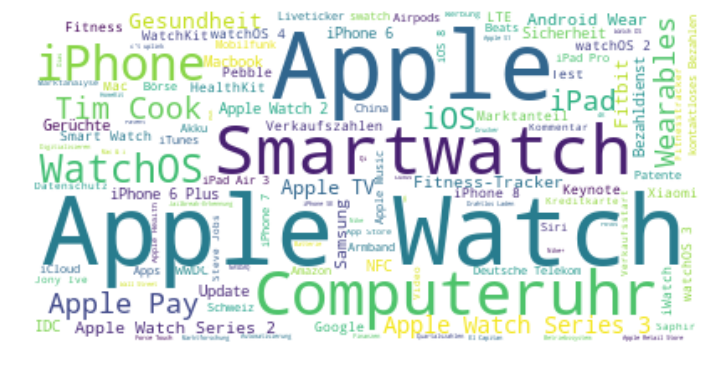

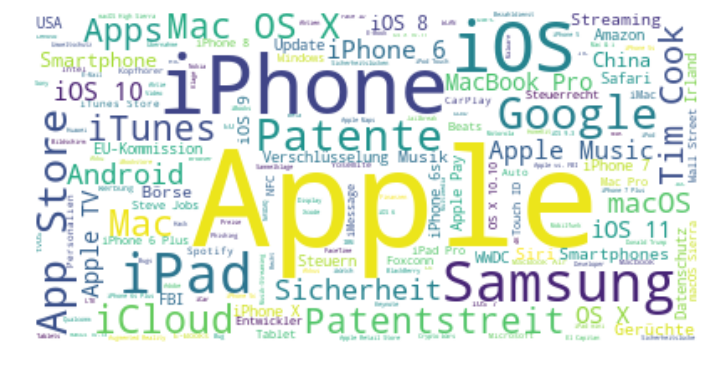

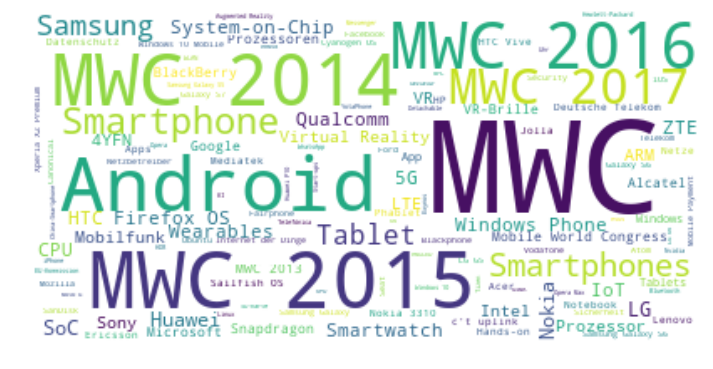

In [18]:
wordcloud_cluster_summary(k_means)

Hier nochmal zum Vergleich die deutlich unübersichtlichere (aber quantitative) Textausgabe:

In [19]:
print_cluster_summary(k_means)

label 0 with 2095 articles
    2095 Microsoft
     359 Windows
     200 Windows 10
     161 Windows 8
     115 Google
     113 Patchday
     103 Windows Phone
      96 Cloud Computing
      92 Internet Explorer
      91 Nokia
label 1 with 69310 articles
    3480 Datenschutz
    2287 Google
    2281 Android
    1953 Überwachung
    1528 NSA
    1491 Spiele
    1452 Smartphone
    1196 USA
    1061 Urheberrecht
    1037 Linux
label 2 with 1443 articles
    1443 Facebook
     214 Datenschutz
     143 Twitter
     122 Google
      88 Social Network
      84 Soziale Netzwerke
      82 WhatsApp
      81 Social Networks
      60 Messenger
      58 Werbung
label 3 with 196 articles
     191 Apple Watch
     175 Apple
      83 Smartwatch
      65 Computeruhr
      36 iPhone
      22 WatchOS
      12 iOS
      12 Tim Cook
      11 iPad
      11 Wearables
label 4 with 3979 articles
    3979 Apple
     791 iPhone
     574 iOS
     335 Samsung
     335 iPad
     205 Google
     194 Patente
     179

<h2>Qualitätskontrolle</h2>

Die Güte des Clustering lässt sich durch unterschiedliche Verfahren messen. scikit-leran beherrscht dafür den Silhouette- und den Calinski-Harabaz-Score. Der Silhouette-Score braucht extrem viel Speicher, der Calinski-Harabaz-Score funktioniert mit 32 GB gerade so.

Mehr Informationen zu den Scores: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html und http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [20]:
from sklearn.metrics import calinski_harabaz_score

Unserer Erfahrung nach arbeitet der Calinski-Harabaz-Score mit dichten Matrizen deutlich schneller.

In [21]:
m = matrix.todense()

Achtung, bitte die folgende Zeile nur auskommentieren, wenn 32 GB oder mehr Hauptspeicher zur Verfügung steht. Es sollte sich ein Score von 471 ergeben.

In [22]:
calinski_harabaz_score(m, k_means.labels_)

471.39315884016128

<h1>Machine-Learning mit den Artikeltexten selbst</h1>

Die Vergabe von Keywords ist subjektiv und möglicherweise haben auch nicht alle Autoren gleiche Krtierien benutzt.
Daher bietet es sich an, das Custering mit den Artikeltexten selbst durchzuführen.

<h2>Vorbereitung der Texte mit spaCY</h2>

Die Informationen in den Texten sind größtenteils in den Substantiven enthalten. Durch die Benutztung von spaCY können diese ausgefiltert und auf ihre Grundform reduziert werden. Das Ergebnis article_nouns ist eine Liste mit einem Eintrag für jedes Dokument, der die Substantive dieses Dokumemts mit Leerzeichen getrennt. Grund dafür: Alle folgenden Verfahren arbeiten mit fortlaufenden Texten und nicht mit Arrays.

Mehr Informationen zu spaCY: https://spacy.io

In [23]:
import spacy
from spacy.lang.de import German
from spacy.lang.de.stop_words import STOP_WORDS

# Einige Worte kommen sehr häufig in den Meldungen vor und tragen wenig zum
# Inhalt bei. Diese werden daher den Stopword zugefügt.
STOP_WORDS.update(["Million", "Milliarde", "Version", "Prozent", "Euro", "US-Dollar",
                   "Dollar", "padding-top", "%", "Jahr", "Quartal", "Zeit", "Datum"])

nlp = spacy.load('de')

articles_nouns = []
for year in range(2010, 2018):
    with open("%d.json" % year) as json_data:
        y = json.load(json_data)
        for article in y:
            # evtl. hier Bindestriche durch Leerzeichen ersetzen
            doc = nlp(article["headline"] + " " + article["text"])
            nouns = []
            for n in map(lambda x: x.lemma_, filter(lambda x: (x.pos_ == 'NOUN') and (x.lemma_ not in STOP_WORDS), doc)):
                # evtl. hier Worte mit führenden Ziffern weglassen
                nouns.append(n) 
            articles_nouns.append(" ".join(nouns))

<h2>Umwandlung in Vektoren</h2>

Die Umwwandlung von Texte in Vektoren geschieht in mehreren Stufen.

Zunächst werden die Anzahl der Worte in den Dokumenten gezählt. Der CountVectorizer lässt dabei in der Standardkonfiguration Worte weg, die nur 1x vorkommen - sehr praktisch, denn diese können über die Abstandsmetrik (Skalarprodukt) ohnehin keinen Beitrag leisten, wei jeder andere Vektor dort ja eine 0 stehen hat.

Mehr Informationen zum CountVectorizer: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
# wenn zu groß, dann mit max_features=N verkleinerbar
cv = CountVectorizer(max_features=350000)
count_vectors = cv.fit_transform(articles_nouns)

Die Struktur der Daten überprüfen, es sind 77.410 Dokumente mit 300.510 unterschiedlichen Wörtern ==> eine sehr große, dünn besetzte Matrix.

In [27]:
count_vectors.shape

(77410, 300510)

Das TF/IDF-Format berücksichtigt, dass manche Worte häufiger vorkommen als andere und daher eine geringere Trennschärfe haben. Zusätzlich wird die Anzahl der Worte in einem Dokument mit gewichtet. Die TF/IDF-Matrix kann aus der oben berechneten Count-Matrix abgeleitet werden.

Mehr Informationen zum TfidfTransformer: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

scikit-learn kann auch beide Schritt auf einmal erledigen: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=True)
tfidf_vectors = tfidf.fit_transform(count_vectors)

Diese Daten können direkt für das Clustering verwendet werden:

<h2>Clustering</h2>

Das Clustering funktioniert genau wie bei den Keywords oben, allerdings wird hier etwas mehr Zeit benötigt, da es mehr als siebenmal soviele Worte im Text gibt als Keywords.

In [29]:
np.random.seed(0)
clusters = 6
k_means_text = KMeans(n_clusters=clusters)
k_means_text.fit(tfidf_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

<h2>Ergebnisskontrolle</h2>

Für eine einfacher Ergebniskontrolle kann man sich Statistik-Informationen anzeigen lassen:

In [30]:
np.unique(k_means_text.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([11753,  1045, 49980,  2586,  8954,  3092]))

Ähnlich wie oben soll nun eine Zusammenfassung des Clusterings angezeigt werden. Besonders interessant sind dabei die für das Clustering wichtigsten Worte. Diese ergeben sich aus den größten Komponenten der zusammengezählten TF/IDF-Vektoren in jedem Cluster. Achtung, das sind nicht die häufigsten Worte im Cluster, denn durch die IDF-Normierung werden im gesamten Text häufige Worte unterdrückt.

In [31]:
def print_text_cluster_summary(method, matrix, vectorizer):
    labels = method.labels_
    features = vectorizer.get_feature_names()
    unique_labels, counts = np.unique(labels, return_counts=True)
    for cluster in unique_labels:
        vec = None
        for i, label in enumerate(labels):
            if label == cluster:
                if vec != None:
                    vec += matrix[i] 
                else:
                    vec = matrix[i]
        print("Cluster %d" %cluster)
        # der Vektor hat zwei "Achsen", daher das zusätzliche [0] für die erste
        for f in np.argsort(vec.toarray())[0][-10::]:
            print("  %s" % features[f])

Die Darstellung wird übersichtlicher, wenn man WordClouds verwendet. Achtung, auch hier sind die Wortgrößen im Gegensatz zu den bisherigen WordClouds nicht proportional zur Häufigkeit der Worte im jeweiligen Cluster, sondern zu der über TF/IDF skalierten "Bedeutung".

In [32]:
def wordcloud_text_cluster_summary(method, matrix, vectorizer):
    labels = method.labels_
    features = vectorizer.get_feature_names()
    unique_labels, counts = np.unique(labels, return_counts=True)
    for cluster, count in zip(unique_labels, counts):
        vec = None
        for i, label in enumerate(labels):
            if label == cluster:
                if vec != None:
                    vec += matrix[i] 
                else:
                    vec = matrix[i]
        print("Cluster %d with size %d" % (cluster, count))
        # der Vektor hat zwei "Achsen", daher das zusätzliche [0] für die erste
        freq = {}
        for f in np.argsort(vec.toarray())[0][-100::]:
            freq[features[f]] = int(vec[0,f] * 1000.0)
        wc = WordCloud(background_color="white", max_words=100)
        wc.generate_from_frequencies(freq)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off");


Wie oben werden die Clustergrößen als Fortschrittsindikator ausgegeben.

Cluster 0 with size 11753
Cluster 1 with size 1045
Cluster 2 with size 49980
Cluster 3 with size 2586
Cluster 4 with size 8954
Cluster 5 with size 3092


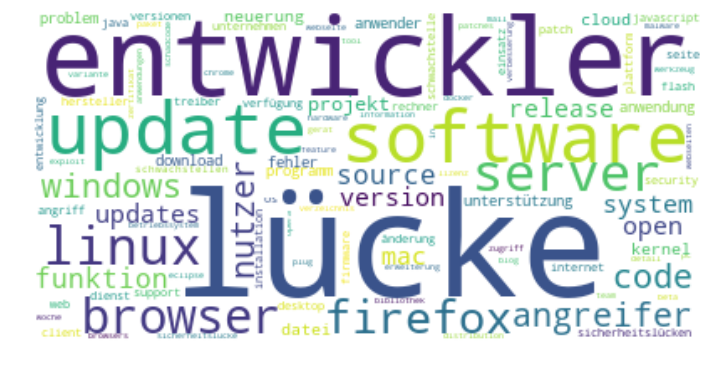

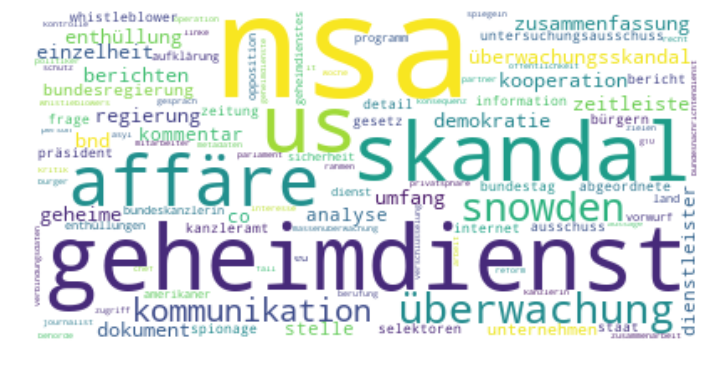

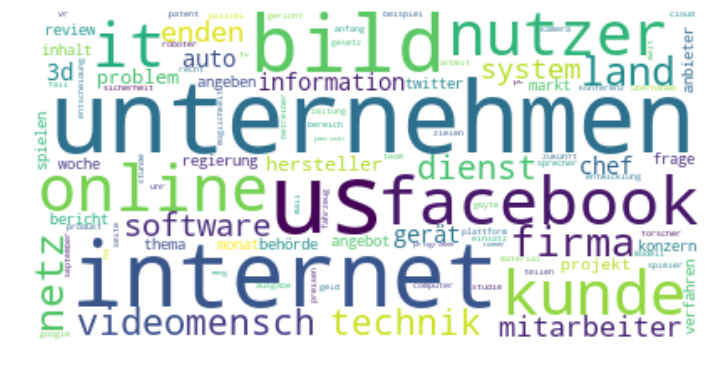

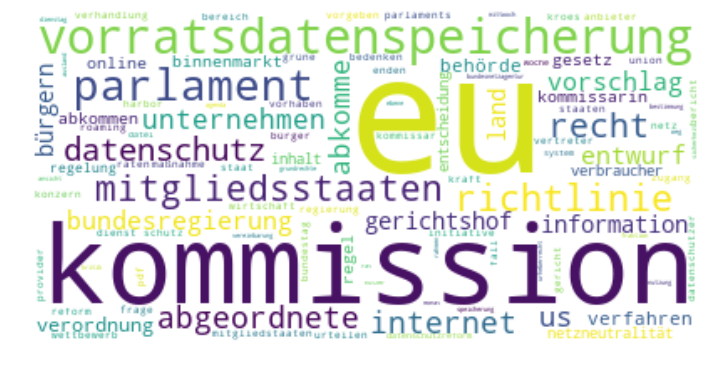

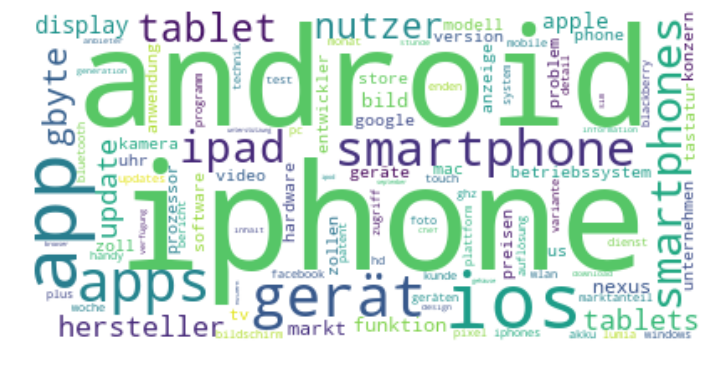

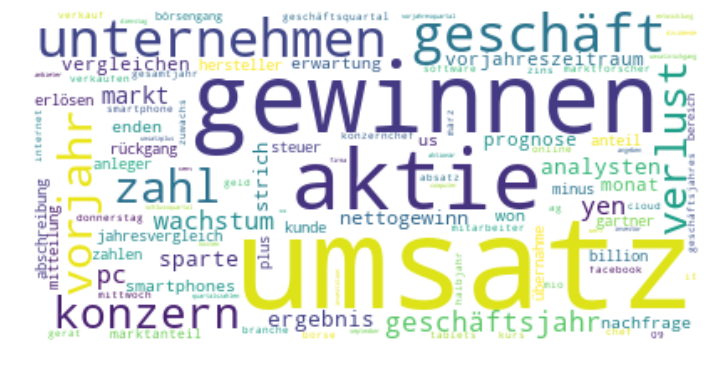

In [35]:
wordcloud_text_cluster_summary(k_means_text, tfidf_vectors, cv)

Zum Vergleich nochmal die Ausgabe der Worte selbst:

In [36]:
print_text_cluster_summary(k_means_text, tfidf_vectors, cv)

Cluster 0
  windows
  angreifer
  firefox
  browser
  linux
  server
  software
  update
  entwickler
  lücke
Cluster 1
  regierung
  überwachungsskandal
  kommunikation
  snowden
  überwachung
  affäre
  skandal
  us
  geheimdienst
  nsa
Cluster 2
  firma
  it
  kunde
  nutzer
  online
  facebook
  bild
  internet
  us
  unternehmen
Cluster 3
  abgeordnete
  internet
  datenschutz
  recht
  mitgliedsstaaten
  richtlinie
  parlament
  vorratsdatenspeicherung
  kommission
  eu
Cluster 4
  tablet
  ipad
  smartphones
  smartphone
  apps
  gerät
  app
  ios
  android
  iphone
Cluster 5
  geschäftsjahr
  verlust
  konzern
  vorjahr
  zahl
  geschäft
  unternehmen
  aktie
  gewinnen
  umsatz


Spaßeshalber lässt sich auch die Ähnlichkeit der jetzt gefundenen Cluster mit den Keyword-Clustern vergleichen. Hier ist keine große Übereinstimmung zu erwarten, da die Datenbasis anders ist.

In [37]:
metrics.adjusted_mutual_info_score(labels1, k_means_text.labels_)

0.12657220005324632

<h1>Topic Modelling mit gensim</h1>

Bisher wurden die Artikel mit unüberwachtem Lernen zu Clustern zusammengefasst. Beim Arbeitem mit Text gibt es aber noch weitere Möglichkeiten, allen voran das sog. Topic Modelling. Für Python existieren mehrere Bibliotheken, am aktivsten ist gensim.

Mehr zu gensim: https://radimrehurek.com/gensim/

gensim kann nicht die Datenstrukturen von scikit-learn weiterverwenden. Die Vorgehehensweise ist aber ähnlich, nur werden hier bereits Wort-Arrays benötigt, aus denen dann ein dictionary aufgebaut wird. Um den Rechenaufwand in Grenzen zu halten, werden "nur" 10.000 Worte benutzt, Worte müssen außerdem mindestens fünfmal vorkommen und nicht dürfen in nicht mehr als 30% aller Artikel verwendet werden.

In [38]:
from gensim import corpora, models, similarities
from spacy.lang.de.stop_words import STOP_WORDS

articles_nouns_array = [a.split(" ") for a in articles_nouns]
dictionary = corpora.Dictionary(articles_nouns_array)
# nur Worte berücksichtigen, die >5x vorkommen und in weniger als 30% der Dokumente
dictionary.filter_extremes(5, no_above=0.3, keep_n=10000)
corpus = [dictionary.doc2bow(doc) for doc in articles_nouns_array]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

gensim bietet unterschiedliche Algorithmen für das Topic Modelling an. Hier wird zunächst LDA, die sog. latente Dirichlet-Allokation verwendet. Mit LDA ließen sich als generatives Verfahren anschließend auch Artikel zu einem bestimmten Topic generieren.

Mehr zu LDA: https://de.wikipedia.org/wiki/Latent_Dirichlet_Allocation

In [39]:
lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=6, passes=2)
lda.print_topics(6)

[(0,
  '0.013*"Umsatz" + 0.010*"Unternehmen" + 0.009*"Konzern" + 0.008*"Geschäft" + 0.008*"Mitarbeiter" + 0.008*"gewinnen" + 0.007*"Zahl" + 0.006*"Aktie" + 0.005*"Wachstum" + 0.005*"Übernahme"'),
 (1,
  '0.003*"Land" + 0.003*"Mensch" + 0.003*"Behörde" + 0.003*"Trump" + 0.003*"Internet" + 0.003*"Regierung" + 0.003*"Frage" + 0.002*"Gesetz" + 0.002*"Staat" + 0.002*"Polizei"'),
 (2,
  '0.013*"Spieler" + 0.010*"spielen" + 0.009*"Auto" + 0.008*"Tesla" + 0.007*"Fahrzeug" + 0.007*"Elektroautos" + 0.006*"Bitcoin" + 0.006*"Drohne" + 0.005*"Patent" + 0.005*"Fahrer"'),
 (3,
  '0.013*"Nutzer" + 0.010*"iOS" + 0.009*"iPhone" + 0.009*"App" + 0.008*"Apps" + 0.007*"Facebook" + 0.007*"Kunde" + 0.006*"Twitter" + 0.006*"Dienst" + 0.006*"Werbung"'),
 (4,
  '0.008*"Bild" + 0.007*"Gerät" + 0.006*"GByte" + 0.005*"iPhone" + 0.005*"Hersteller" + 0.005*"Video" + 0.004*"Kamera" + 0.004*"€" + 0.004*"Smartphone" + 0.004*"Modell"'),
 (5,
  '0.006*"Lücke" + 0.006*"Angreifer" + 0.006*"Entwickler" + 0.005*"Roboter" + 0.

Alternative: HDP

Auch wenn es auf den ersten Blick nicht so aussieht, addieren sich die Wahrscheinlichkeitswerte in jedem Topic zu 100%:

In [40]:
sum([f[1] for f in lda.show_topic(0, topn=10000)])

0.99999999999999889

Die Datenstrukturen in gensim sind für die Darstellung in Wordclouds deutlich besser geeignet, damit ist der Code viel einfacher, der die unterschiedlichen Topics visualisiert:

topic 0
topic 1
topic 2
topic 3
topic 4
topic 5


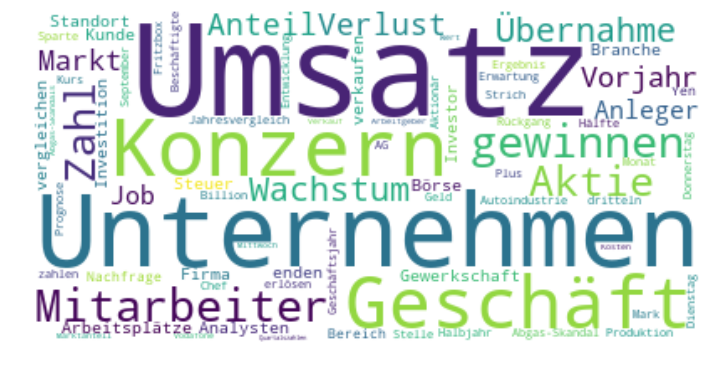

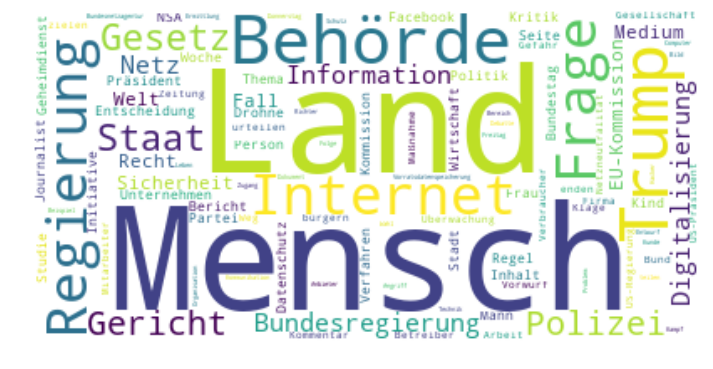

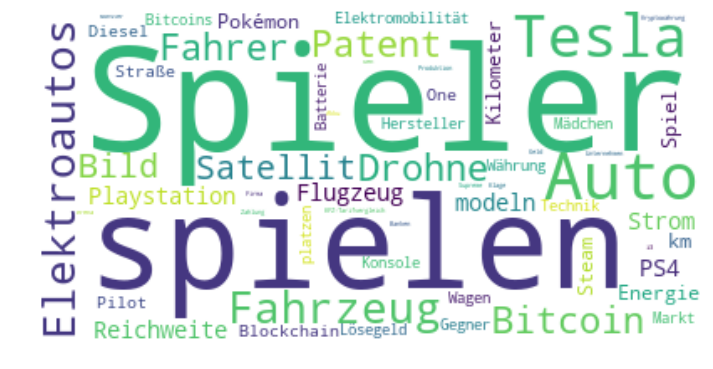

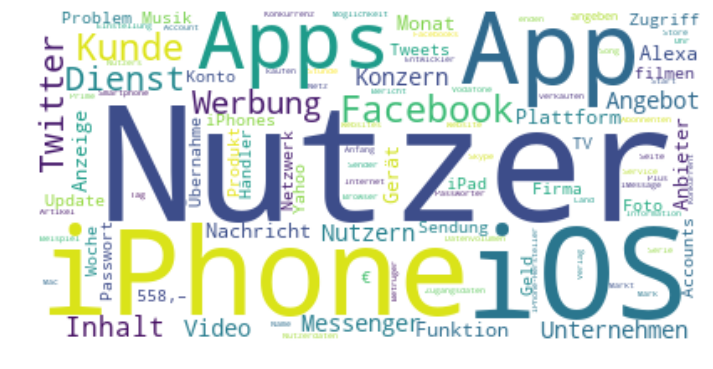

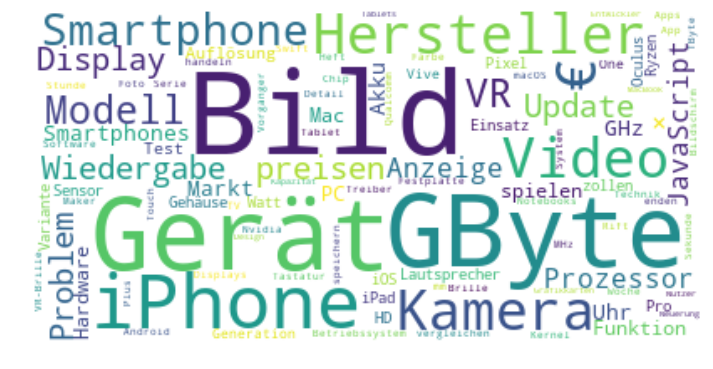

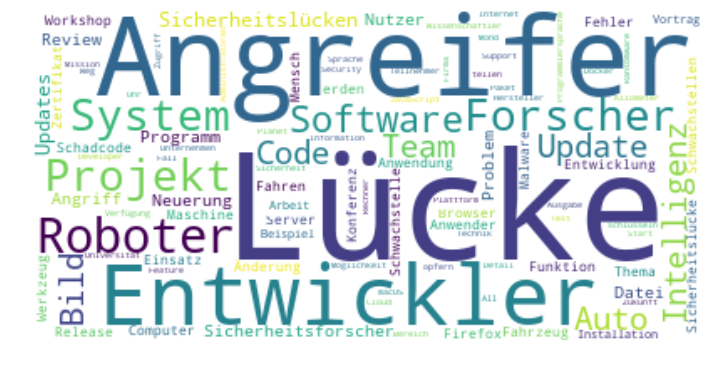

In [41]:
for topic in range(0, 6):
    print("topic %d" % topic)
    freq = {}
    for kv in lda.show_topic(topic,topn=100):
        freq[kv[0]] = int(kv[1] * 1000.0)
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate_from_frequencies(freq)
    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off");


Alternatik kann auch mit dem hierarchischen Dirichlet Prozess gearbeitet werden, um die Topics zu finden:

In [42]:
hdp = models.HdpModel(corpus, id2word=dictionary)

topic 0
topic 1
topic 2
topic 3
topic 4
topic 5


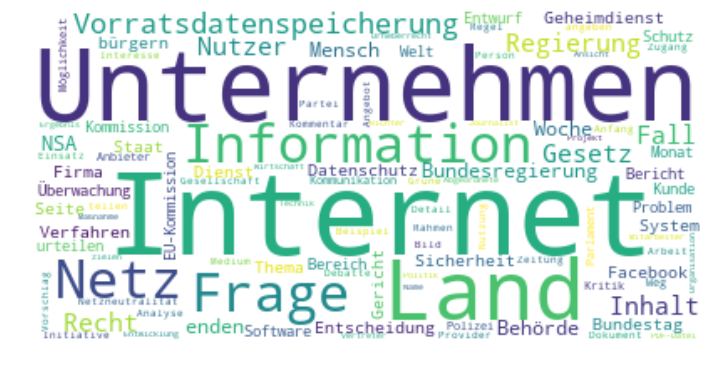

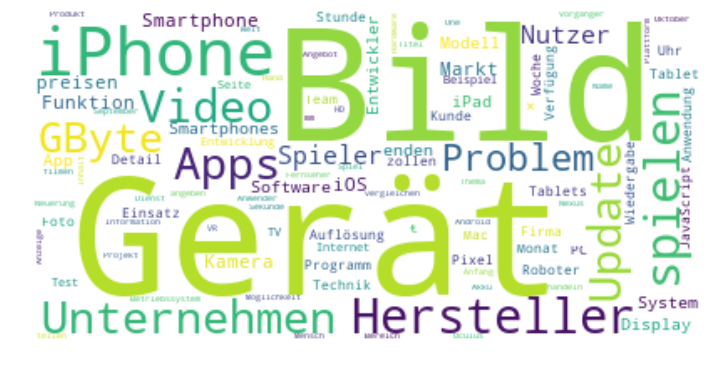

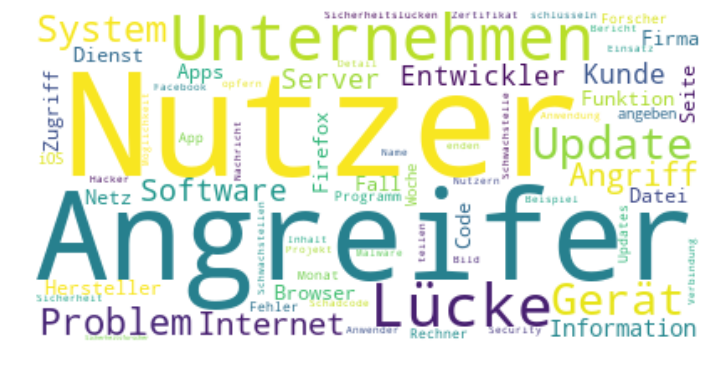

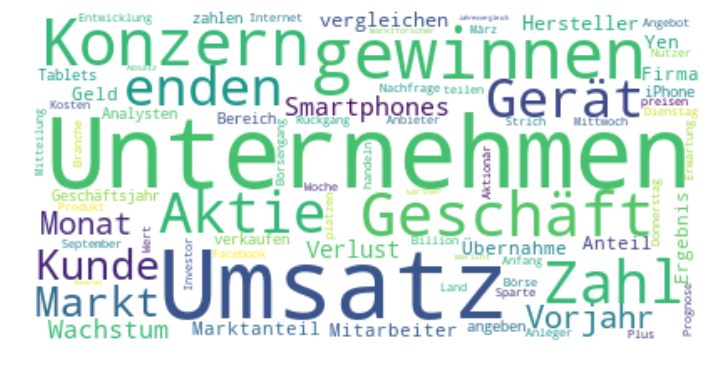

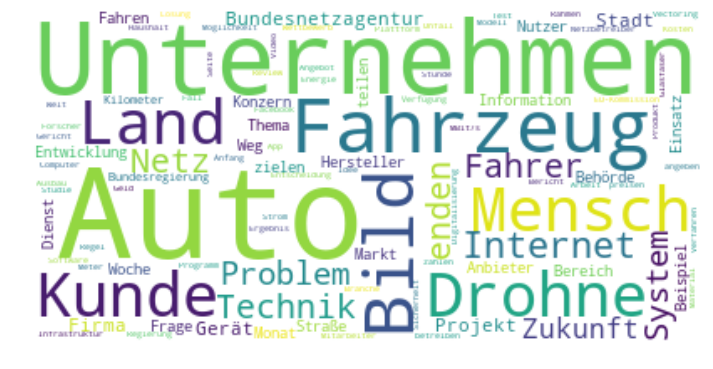

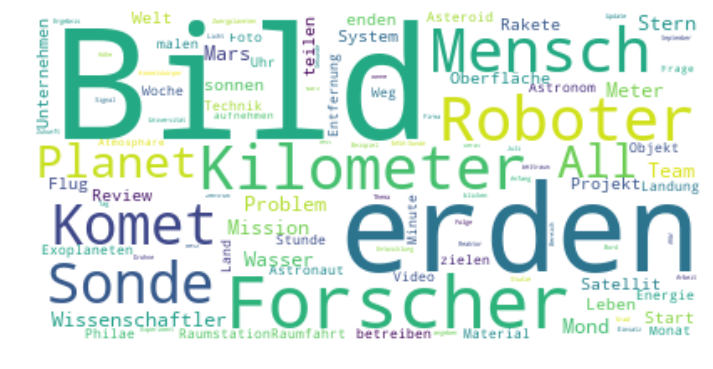

In [43]:
for topic in range(0, 6):
    print("topic %d" % topic)
    freq = {}
    for kv in hdp.show_topic(topic,topn=100):
        freq[kv[0]] = int(kv[1] * 1000.0)
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate_from_frequencies(freq)
    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off");

LSI ist ein Matrix-basiertes Verfahren, in dem auch (schwer zu interpretierende) negative Gewichte vorkommen:

In [44]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=6)
lsi.print_topics(6)

[(0,
  '0.155*"Unternehmen" + 0.142*"Gerät" + 0.137*"Nutzer" + 0.113*"Internet" + 0.112*"iPhone" + 0.112*"Bild" + 0.106*"Update" + 0.103*"Kunde" + 0.102*"Software" + 0.095*"Apps"'),
 (1,
  '0.220*"iPhone" + 0.209*"iOS" + 0.189*"Update" + 0.186*"Lücke" + 0.162*"Gerät" + 0.147*"GByte" + 0.143*"Apps" + 0.124*"Angreifer" + 0.111*"iPad" + 0.106*"App"'),
 (2,
  '0.375*"Lücke" + 0.268*"Angreifer" + -0.181*"GByte" + -0.158*"Umsatz" + -0.139*"Bild" + 0.138*"Angriff" + -0.127*"iPhone" + -0.118*"GHz" + 0.118*"Sicherheitslücken" + 0.114*"Update"'),
 (3,
  '0.401*"Umsatz" + 0.210*"gewinnen" + 0.191*"iPhone" + -0.164*"Bild" + 0.160*"Unternehmen" + -0.156*"NSA" + -0.153*"GByte" + 0.146*"Aktie" + 0.130*"iOS" + -0.127*"GHz"'),
 (4,
  '0.416*"Patent" + 0.374*"iPhone" + 0.205*"NSA" + -0.184*"Umsatz" + 0.183*"iOS" + 0.158*"Gericht" + 0.151*"Klage" + -0.133*"Auto" + 0.122*"iPad" + 0.122*"Verfahren"'),
 (5,
  '-0.396*"NSA" + -0.276*"Umsatz" + 0.236*"Patent" + -0.211*"Geheimdienst" + -0.203*"NSA-Skandal" + -

<h1>Word2vec mit gensim<h1>

word2vec ist ein Verfahren, in dem Wörter in Vektorräume "eingebettet" werden. Die Embeddings lassen sich durch neuronale Netzwerke lernen.

Mehr zu word2vec: https://en.wikipedia.org/wiki/Word2vec

Die gensim-Implementierung von word2vec benötigt ein Array von Arrays:

In [47]:
import gensim
w2v = gensim.models.Word2Vec(articles_nouns_array, min_count=5, workers=2, hs=1, negative=0)

Mit den Vektoren kann man rechnen: Microsoft - Google = X - Android, eigentlich sollte sich für X Windows ergeben. Nur knapp daneben...

In [48]:
w2v.wv.most_similar(positive=['Microsoft', 'Android'], negative=['Google'], topn=1)

[('Betriebssystem', 0.6090763807296753)]

word2vec kann auch Worte finden, die nicht gut zusammenpassen:

In [49]:
w2v.wv.doesnt_match("Google Amazon Hund Microsoft Facebook".split(" "))

'Hund'

Die Heise-Daten sind recht universell, das geht auch umgekehrt:

In [50]:
w2v.wv.doesnt_match("Hund Katze Maus Facebook".split(" "))

'Facebook'

Ähnlichkeiten zwischen Worten können auch festgestellt werden, word2vec hat das aus der Verwendung der Begriffe in engem Zusammenhang gelernt.

In [51]:
w2v.wv.most_similar(positive=['Google'])

[('Suchmaschinenriese', 0.683860182762146),
 ('Suchmaschine', 0.6535072326660156),
 ('Internet-Konzern', 0.6311419010162354),
 ('Suchergebnisse', 0.5896155834197998),
 ('Internet-Suche', 0.5658557415008545),
 ('Google-Dienste', 0.5539693236351013),
 ('Google-Manager', 0.5400979518890381),
 ('Internetkonzern', 0.5391035079956055),
 ('Google-Suche', 0.5380203127861023),
 ('Suchergebnissen', 0.5336907505989075)]